#### Loading neccessary modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm

plt.style.use('dark_background')

tqdm.tqdm.pandas()

%matplotlib inline

In [2]:
! unzip *.zip
! ls

Archive:  data.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 3D_lstm_sub.csv     naive_approach.csv			   temp_model.h5
challenge_data.csv  sample_data				   test.csv
data.zip	    sample_submission_J0OjXLi_DDt3uQN.csv  train.csv


In [3]:
train = pd.read_csv("train.csv")
challenge_data = pd.read_csv("challenge_data.csv", parse_dates=['publish_date'], infer_datetime_format=True)
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission_J0OjXLi_DDt3uQN.csv")

train.shape, test.shape, sample_sub.shape, challenge_data.shape

((903916, 4), (397320, 4), (119196, 2), (5606, 9))

### EDA:

In [3]:
train.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,1,CI23714
1,4576_2,4576,2,CI23855
2,4576_3,4576,3,CI24917
3,4576_4,4576,4,CI23663
4,4576_5,4576,5,CI23933


In [4]:
test.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4577_1,4577,1,CI23855
1,4577_2,4577,2,CI23933
2,4577_3,4577,3,CI24917
3,4577_4,4577,4,CI24915
4,4577_5,4577,5,CI23714


In [5]:
challenge_data.head()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
0,CI23478,2,SI2445,37.0,2006-06-05,AI563576,M,AOI100001,NaN
1,CI23479,2,SI2435,48.0,2002-10-17,AI563577,M,AOI100002,32.0
2,CI23480,1,SI2435,15.0,2002-10-16,AI563578,M,AOI100003,NaN
3,CI23481,1,SI2710,236.0,2003-09-19,AI563579,M,AOI100004,70.0
4,CI23482,2,SI2440,137.0,2002-03-21,AI563580,M,AOI100005,NaN


In [6]:
sample_sub.head()

,user_sequence,challenge
0,4577_11,CI23648
1,4577_12,CI23648
2,4577_13,CI23648
3,4578_11,CI23648
4,4578_12,CI23648


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903916 entries, 0 to 903915
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_sequence       903916 non-null  object
 1   user_id             903916 non-null  int64 
 2   challenge_sequence  903916 non-null  int64 
 3   challenge           903916 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.6+ MB


The `user_sequence` and the `challenge_sequence` seems rather redundant. Let's check if we can drop the column:

In [8]:
(
    (train.user_sequence.str.extract("_(\d+)")[0].astype(int) == train.challenge_sequence).all(),
    (test.user_sequence.str.extract("_(\d+)")[0].astype(int) == test.challenge_sequence).all(),
)

(True, True)

In [4]:
test.drop("user_sequence", axis=1, inplace=True)

In [5]:
train.drop("user_sequence", axis=1, inplace=True)

How many users, challenges are we dealing with?

In [11]:
train.nunique()

user_id               69532
challenge_sequence       13
challenge              5348
dtype: int64

In [12]:
challenge_data.challenge_ID.nunique()

5606

Note that the challenge data has ID's that are not present in the train dataset, perhaps for use in the test dataset.

In [13]:
# sanity-check. All user appear only 13 times?
(train.user_id.value_counts() == 13).all()

True

### Check for missing data:

While the test and train donot have missing values, the challenge data is quite challenging with a quite a lot of missing data ;)

In [14]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

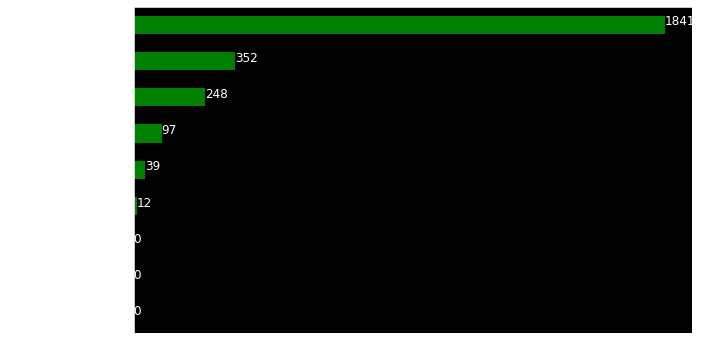

In [15]:
temp = challenge_data.isna().sum().sort_values()
ax = temp.plot(kind='barh', figsize=(10, 6), color='g')
for i, (name, value) in enumerate(temp.iteritems()):
    ax.text(value, i, value, fontdict={"size":12})

#### Let's first visualise the distribution of the challenges:

The dist is so skewed that we have to visualize them with `log` scale:

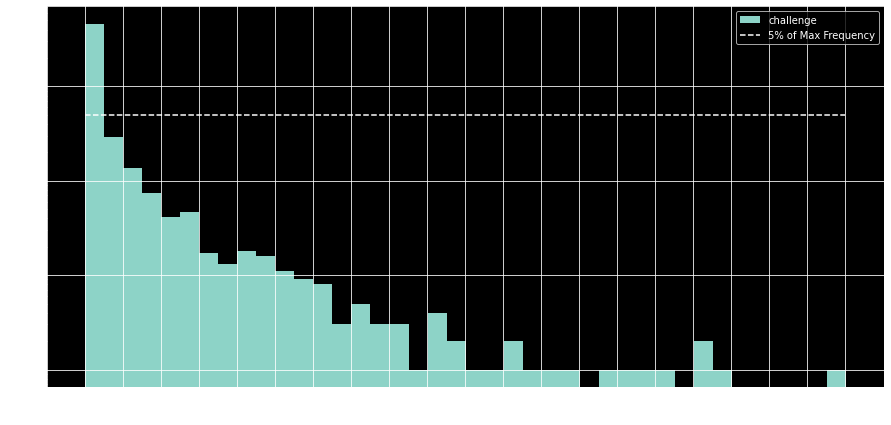

In [16]:
train.challenge.value_counts().plot(kind='hist', figsize=(15, 7),  bins=40, grid=1)
plt.yscale('log')
plt.xlabel("Total Submissions")
plt.ylabel("Frequency")
plt.hlines(.05*1e4, 0, 1e4, label='5% of Max Frequency', 
           color='w', linestyles='dashed')

plt.xticks(range(0, int(1e4+1), 500))
plt.legend();

Majority of the challenges have been attempted less than 500 times. Nearly 95% of challenges have been attempted less than 500 times. Only about 5% of the challenges were attempted more than 500 times!

In [17]:
print (
    "% of challenges attempted more than 500 times:", 
    (train.challenge.value_counts() > 500).sum() / train.challenge.nunique() * 100
)

print (
    "% of challenges attempted less than 500 times:", 
    (train.challenge.value_counts() < 500).sum() / train.challenge.nunique() * 100
)

% of challenges attempted more than 500 times: 7.984293193717278
% of challenges attempted less than 500 times: 92.01570680628272


#### Let's check out in depth about these top 10 best performing challenges & worst performing challenges:

In [18]:
challenge_data.loc[challenge_data.challenge_ID.isin(train.challenge.value_counts().nlargest(10).index)]

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
185,CI23663,1,SI2472,8897.0,2004-09-15,AI563724,M,AOI100098,45.0
213,CI23691,1,SI2469,4823.0,2005-05-25,AI563749,M,AOI100125,33.0
236,CI23714,1,SI2477,14723.0,2006-12-06,AI563766,M,AOI100129,29.0
370,CI23848,1,SI2472,3395.0,2004-09-16,AI563867,M,AOI100204,61.0
377,CI23855,1,SI2468,20993.0,2006-07-24,AI563823,M,NaN,29.0
455,CI23933,1,SI2468,15086.0,2006-07-27,AI563783,M,AOI100149,31.0
1052,CI24530,1,SI2501,6814.0,2006-09-26,AI563815,M,AOI100173,29.0
1439,CI24917,1,SI2545,43409.0,2007-02-07,AI564588,F,AOI100581,66.0
1480,CI24958,1,SI2545,6842.0,2007-09-07,AI564617,F,AOI100085,41.0
1657,CI25135,1,SI2556,5446.0,2007-08-25,AI563754,M,AOI100129,61.0


In [19]:
challenge_data.loc[challenge_data.challenge_ID.isin(train.challenge.value_counts().nsmallest(10).index)]

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
21,CI23499,2,SI2437,35.0,2006-10-14,AI563596,M,AOI100011,23.0
2178,CI25656,1,SI2526,199.0,2007-11-29,AI565132,M,AOI100894,57.0
2482,CI25960,1,SI2602,236.0,2007-11-10,AI565333,F,AOI100999,97.0
2614,CI26092,1,SI2627,44.0,2008-11-03,AI565432,M,AOI101042,26.0
2785,CI26272,1,SI2641,51.0,2008-04-22,AI565512,M,AOI101005,163.0
3935,CI27431,1,SI2690,32.0,2008-10-21,AI566158,M,AOI100609,214.0
4520,CI28054,3,SI2757,17.0,2008-02-14,AI566489,M,AOI101451,192.0
5181,CI28959,1,SI2850,24.0,2009-12-17,AI566838,M,AOI101514,NaN
5543,CI28901,1,SI2838,NaN,2009-12-12,AI565727,M,AOI101183,NaN
5579,CI29047,1,SI2860,NaN,2010-08-05,AI567042,M,AOI101707,28.0


##### Let's find out what the most popular pgming choice for first attempt, second attempt and so on for a user would be from the train dataset:

In [20]:
temp = train.groupby(["challenge_sequence"])["challenge"].apply(lambda x: x.value_counts().nlargest(50).index.to_list())
most_pop_train = np.unique(np.ravel(temp.to_list()), return_counts=True)
most_pop_train = most_pop_train[0][np.argsort(most_pop_train[1])[::-1][:20]]
most_pop_train

array(['CI24530', 'CI24527', 'CI24915', 'CI24917', 'CI24958', 'CI24187',
       'CI25135', 'CI23848', 'CI23855', 'CI23933', 'CI24138', 'CI25075',
       'CI25124', 'CI23714', 'CI24876', 'CI24866', 'CI24534', 'CI24532',
       'CI23769', 'CI25126'], dtype='<U7')

In [21]:
challenge_data[challenge_data.challenge_ID.isin(most_pop_train)].describe(include='object')

,challenge_ID,challenge_series_ID,author_ID,author_gender,author_org_ID
count,20,20,20,20,19
unique,20,10,19,2,14
top,CI24915,SI2501,AI563754,M,AOI100085
freq,1,4,2,16,3


Lets cheat a bit and check what we have got in the test data as well and see how similar they are:

In [22]:
temp = test.groupby("challenge_sequence")["challenge"].apply(lambda x: x.value_counts().nlargest(50).index.to_list())

most_pop_test = np.unique(np.ravel(temp.to_list()), return_counts=True)
most_pop_test = most_pop_test[0][np.argsort(most_pop_test[1])[::-1][:20]]
most_pop_test

array(['CI24527', 'CI24915', 'CI24917', 'CI24530', 'CI24187', 'CI25135',
       'CI23848', 'CI23855', 'CI23933', 'CI24138', 'CI25126', 'CI25075',
       'CI23714', 'CI24958', 'CI24876', 'CI24866', 'CI24534', 'CI23769',
       'CI24532', 'CI23913'], dtype='<U7')

In [23]:
len(most_pop_train), len(most_pop_test)

(20, 20)

In [24]:
len(np.intersect1d(most_pop_train, most_pop_test))

19

In [25]:
np.setdiff1d(most_pop_test, most_pop_train), np.setdiff1d(most_pop_train, most_pop_test)

(array(['CI23913'], dtype='<U7'), array(['CI25124'], dtype='<U7'))

The most popular ones in the test dataset are still the same as in the train dataset with the exception of a very few.

#### Let's dive into performing EDA on challenge_data:

In [26]:
challenge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   challenge_ID          5606 non-null   object        
 1   programming_language  5606 non-null   int64         
 2   challenge_series_ID   5594 non-null   object        
 3   total_submissions     5254 non-null   float64       
 4   publish_date          5606 non-null   datetime64[ns]
 5   author_ID             5567 non-null   object        
 6   author_gender         5509 non-null   object        
 7   author_org_ID         5358 non-null   object        
 8   category_id           3765 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 394.3+ KB


How many unique values?

In [27]:
challenge_data.nunique()

challenge_ID            5606
programming_language       3
challenge_series_ID      435
total_submissions       1067
publish_date            1145
author_ID               3484
author_gender              2
author_org_ID           1717
category_id              194
dtype: int64

Which programming language is the most popular?

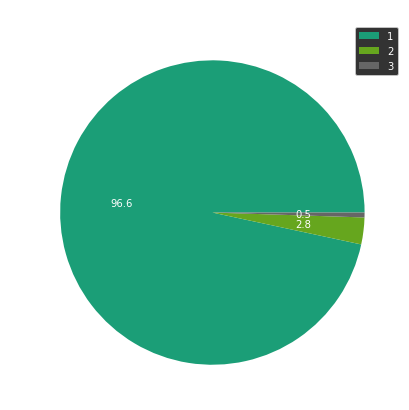

In [28]:
(challenge_data
 .groupby("programming_language")
 ['total_submissions'].sum()
 .plot(kind='pie', figsize=(7, 7), 
       autopct=lambda x: '{0:2.1f}'.format(x),
      title='Language Popularity', cmap='Dark2'))

plt.legend();

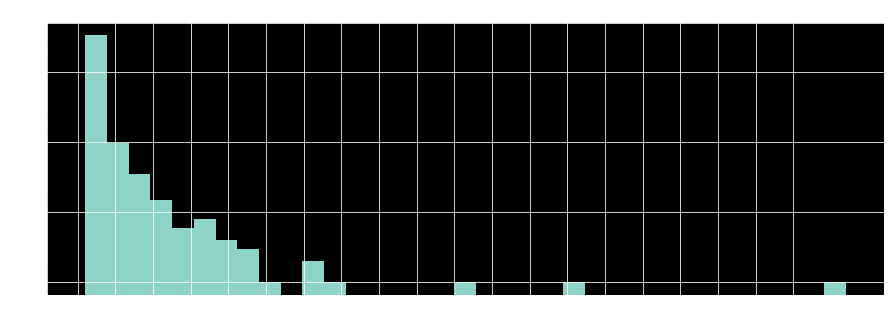

In [29]:
challenge_data.author_ID.value_counts().plot(kind='hist', bins=35, figsize=(15, 5), grid=True)
plt.yscale('log')
plt.title("Vast majority of Authors have prepared very few challenges!")
plt.ylabel("Author Count")
plt.xlabel("No. of challenges made")
plt.xticks(range(0, 100, 5));

Lets rank the authors according to their contribution:

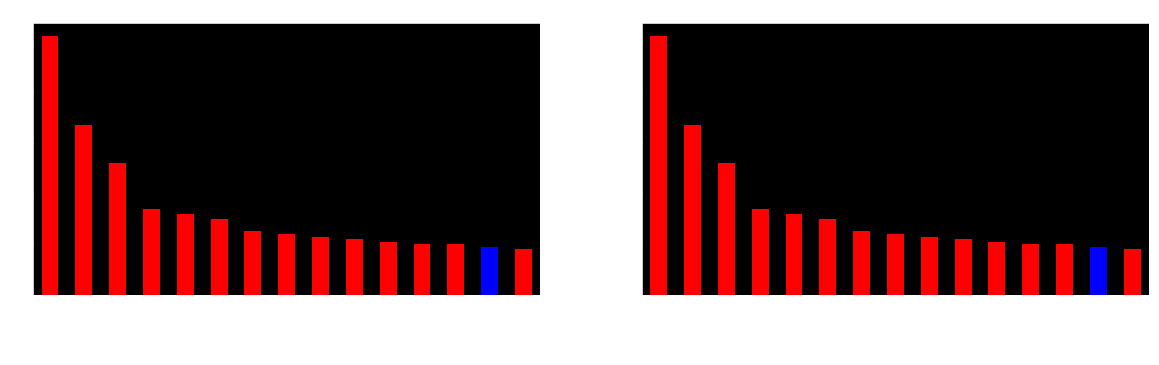

In [30]:
f, ax = plt.subplots(ncols=2, figsize=(20, 5))

gender_map = {"M": (1, 0, 0), "F": (0, 0, 1)}
top_n = 15

# Lets check out the authors who have produced the greatest no of challenges
temp = (challenge_data.groupby('author_ID')
        .agg({"challenge_ID":'count', "author_gender": 'max'})
        .nlargest(top_n, columns=['challenge_ID']))

temp['challenge_ID'].plot(kind='bar', ax=ax[0], rot=45, color=temp["author_gender"].map(gender_map))
ax[0].set_title("Authors who made largest no of challenges");

# Lets check out the authors who have produced the greatest no of challenge series
temp = (challenge_data.groupby('author_ID')
        .agg({"challenge_series_ID":'count', "author_gender": 'max'})
        .nlargest(top_n, columns=['challenge_series_ID']))

temp['challenge_series_ID'].plot(kind='bar', ax=ax[1], rot=45, color=temp["author_gender"].map(gender_map))
ax[1].set_title("Authors who made largest no of challenge series");

Let's group the author and check for their popularity:

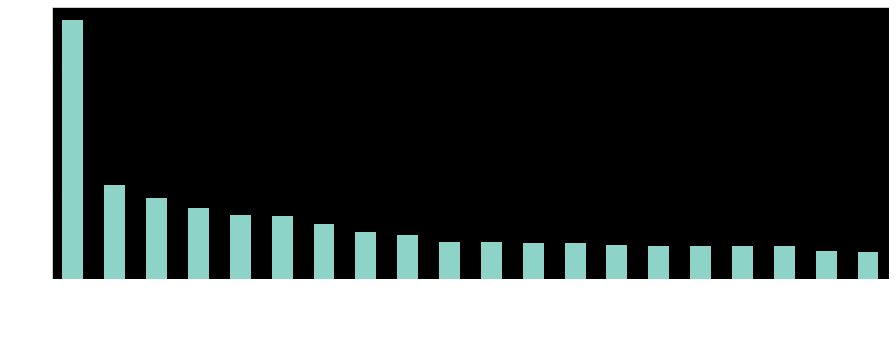

In [31]:
# one author has much larger success than the others almost 2x the others
challenge_data.groupby('author_ID')['total_submissions'].sum().nlargest(20).plot(kind='bar', figsize=(15, 5))

##### Let's count the number of users and the total number of challenges available:

In [5]:
n_users = np.unique(np.concatenate((train.user_id.unique(), test.user_id.unique()))).shape[0]

n_challenges = challenge_data.challenge_ID.nunique()

n_users, n_challenges

(109264, 5606)

It seems that train and test data have entirely different set of users that we need to recommend for:

In [6]:
np.intersect1d(train.user_id.unique(), test.user_id.unique())

array([], dtype=int64)

### One Naive approach:
Before we start with the actual modelling lets submit a naive solution of suggesting the most popular ones from the train dataset randomly provided the user hasn't already attempted the same challenge:

`Note:` The competition uses MAP (mean avg precision) where the order matters (partially). If all our guesses are correct then the order is irrelevant, however if we have a incorrect prediction before a correct one, then our score goes down. *Therefore, __It is important to put our best guesses first.__* 

In [34]:
# Luckily no user ever reattempts a solved pbm
train.groupby("user_id")["challenge"].progress_apply(lambda x: x.nunique()).min()

100%|██████████| 69532/69532 [00:15<00:00, 4483.24it/s]


13

In [35]:
temp = (test.groupby("user_id")["challenge"].progress_apply(
    lambda x: pd.Series(np.setdiff1d(most_pop_test, x, assume_unique=True)[:3]))
).reset_index()

temp["user_sequence"] = temp['user_id'].astype(str) + "_" + (temp['level_1'] + 11).astype(str)
temp = temp.loc[:, ["user_sequence", "challenge"]]
temp.head()

100%|██████████| 39732/39732 [00:15<00:00, 2551.17it/s]


,user_sequence,challenge
0,4577_11,CI24527
1,4577_12,CI24187
2,4577_13,CI23848
3,4578_11,CI24527
4,4578_12,CI24530


In [36]:
temp.to_csv("naive_approach.csv", index=False)

That made a score of 0.0096363636.

#### Modelling the data:

Let's make a LSTM model that given a sequence tries to predict the next possible recommendation. 

Each sequence is fed thrice to our model along with partial predictions. Its job is to simply predict the next in sequence given 10 challenges + *partial_challenges* as input. Let's prepare the dataframe just for that:

In [6]:
# we combine the test and train to be able to create
# a mapping for the challenges
data = pd.concat([train, test])
data.challenge = data.challenge.astype("category")

# let's create and save the mapping
rev_mapping = dict(enumerate(data.challenge.cat.categories))
mapping = dict(map(lambda x: (x[1], x[0]), rev_mapping.items()))

# let's now convert them into codes
data['ccode'] = data.challenge.map(mapping).astype(int)

data.head()

,user_id,challenge_sequence,challenge,ccode
0,4576,1,CI23714,233
1,4576,2,CI23855,374
2,4576,3,CI24917,1421
3,4576,4,CI23663,182
4,4576,5,CI23933,451


In [7]:
# split the train and test set back from DF
train = data.iloc[:train.shape[0]]
test = data.iloc[train.shape[0]:]

In [8]:
# groupby the user_id to generate x, y's
train_data = train.groupby("user_id")['ccode'].progress_apply(lambda x: (x.values[:10], x.values[10:]))
# split into x and y seperately
train_data = train_data.progress_apply(pd.Series).rename({0: "X", 1: "Y"}, axis=1)

# how does it look?
train_data.head()

100%|██████████| 69532/69532 [00:15<00:00, 4544.78it/s]


,X,Y
user_id,,
4576,"[233, 374, 1421, 182, 451, 1636, 493, 1627, 14...","[1462, 186, 210]"
4580,"[182, 374, 451, 493, 1039, 233, 167, 300, 186,...","[1419, 2222, 2542]"
4581,"[2643, 2644, 2645, 2646, 2647, 2648, 2649, 265...","[2651, 2654, 2655]"
4582,"[374, 1419, 1421, 451, 182, 1462, 493, 233, 14...","[1636, 2542, 1461]"
4585,"[374, 493, 1421, 1636, 367, 233, 182, 451, 146...","[1039, 703, 1627]"


Now that we have created the dataframe by grouping by the User_ID, let's proceed with creating the partical challenges. Each row is replicated thrice, for the first row a **null padded** partical sequence is fed as *partial challenge*. For the next row the partial sequence is updated with the first prediction, rest positions are null padded and so on..

Let's create a simple utility function for the purpose:

In [9]:
def expand(row, padding=data.ccode.max()+1):
    '''Given a DF row containing 3 values, it creates the partial 
    labels as explained above. `Padding` is the NULL PAD VALUE'''

    X = row[0]
    y = row[1]

    pad = [padding] * 3
    Y = [list(pad)]

    for i in range(3):
        temp = list(Y[-1])
        temp[i] = y[i]
        Y.append(temp)

    return X, Y

In [10]:
# applying the function returns the labels replaced with partial labels
sequence_train = train_data.progress_apply(func=expand, axis=1, result_type='expand')

# Split the list into indiviual rows (3x)
sequence_train = (sequence_train
                  .merge(sequence_train[1]
                  .progress_apply(pd.Series).stack()
                  .reset_index(level=1), left_index=True, right_index=True)
)

sequence_train = sequence_train.drop([1, 'level_1'], axis=1)

# we create the targets once again from the partial labels
# but instead of having all the target challenges together 
# we have them in 3 different rows sequentially

sequence_train['target'] = (sequence_train["0_y"].shift(-1)
.transform(lambda x: x[max(np.where(np.array(x) != 5502)[0], default=0)] 
           if type(x) != float else x)
)

# only retain the top three rows (since last row contains NULL value as the target)
sequence_train = sequence_train.groupby('user_id').head(3)
sequence_train = sequence_train.rename({"0_x": "Prev_Challenges", "0_y": "P_Targets"}, axis=1)
# instead of 3 partial targets we retain only 2 since 3rd one is always NULL
sequence_train['P_Targets'] = sequence_train['P_Targets'].transform(lambda x: x[:2])
sequence_train.head()

100%|██████████| 69532/69532 [00:13<00:00, 4989.47it/s]


,Prev_Challenges,P_Targets,target
user_id,,,
4576,"[233, 374, 1421, 182, 451, 1636, 493, 1627, 14...","[5502, 5502]",1462.0
4576,"[233, 374, 1421, 182, 451, 1636, 493, 1627, 14...","[1462, 5502]",186.0
4576,"[233, 374, 1421, 182, 451, 1636, 493, 1627, 14...","[1462, 186]",210.0
4580,"[182, 374, 451, 493, 1039, 233, 167, 300, 186,...","[5502, 5502]",1419.0
4580,"[182, 374, 451, 493, 1039, 233, 167, 300, 186,...","[1419, 5502]",2222.0


###Creating the model:
Now that we are done creating the data, let's create the model with a simple function.

    Optimum Output Dim -> min(50, InputDim/2)

In [66]:
def create_em_model(odim=50):
    pc_inp = tf.keras.layers.Input(shape=(10,))
    pt_inp = tf.keras.layers.Input(shape=(2,))

    concat = tf.keras.layers.Concatenate()([pc_inp, pt_inp])
    em = tf.keras.layers.Embedding(input_dim=data.ccode.max()+2, output_dim=odim)(concat)
    dropout = tf.keras.layers.Dropout(0.25)(em)
    lstm1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(dropout)
    lstm2 = tf.keras.layers.LSTM(units=128)(lstm1)

    dense1 = tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')(lstm2)
    dense2 = tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')(dense1)

    op = tf.keras.layers.Dense(units=data.ccode.max()+1, activation='softmax')(dense2)

    model = tf.keras.models.Model(inputs=[pc_inp, pt_inp], outputs=op)

    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(0.001), 
        metrics=tf.keras.metrics.SparseCategoricalAccuracy("SCAcc"))

    return model

In [67]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [68]:
tf.keras.backend.clear_session()

with strategy.scope():
    model = create_em_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 50)       275150      concatenate[0][0]            

In [69]:
hist = model.fit(
    x = [np.stack(sequence_train['Prev_Challenges']), np.stack(sequence_train['P_Targets'])],
    y = sequence_train['target'],
    epochs=100, validation_split=0.2, batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_SCAcc', mode='max'),
               tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1,
                                                    monitor='val_SCAcc', mode='max')]
)

Epoch 1/100
2608/2608 [==============================] - 25s 10ms/step - SCAcc: 0.0300 - loss: 5.7209 - val_SCAcc: 0.0278 - val_loss: 5.8792 - lr: 0.0010
Epoch 2/100
2608/2608 [==============================] - 24s 9ms/step - SCAcc: 0.0539 - loss: 4.9003 - val_SCAcc: 0.0357 - val_loss: 5.6152 - lr: 0.0010
Epoch 3/100
2608/2608 [==============================] - 23s 9ms/step - SCAcc: 0.0657 - loss: 4.6486 - val_SCAcc: 0.0407 - val_loss: 5.4502 - lr: 0.0010
Epoch 4/100
2608/2608 [==============================] - 24s 9ms/step - SCAcc: 0.0768 - loss: 4.4897 - val_SCAcc: 0.0492 - val_loss: 5.4432 - lr: 0.0010
Epoch 5/100
2608/2608 [==============================] - 23s 9ms/step - SCAcc: 0.0866 - loss: 4.3650 - val_SCAcc: 0.0562 - val_loss: 5.4064 - lr: 0.0010
Epoch 6/100
2608/2608 [==============================] - 24s 9ms/step - SCAcc: 0.0969 - loss: 4.2595 - val_SCAcc: 0.0617 - val_loss: 5.4690 - lr: 0.0010
Epoch 7/100
2608/2608 [==============================] - 24s 9ms/step - SCAcc: 0.

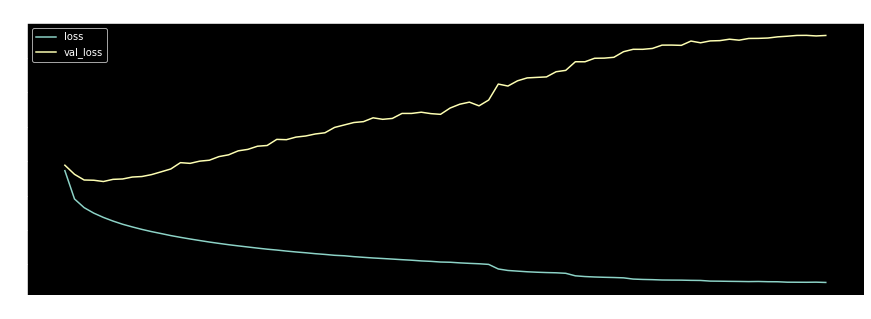

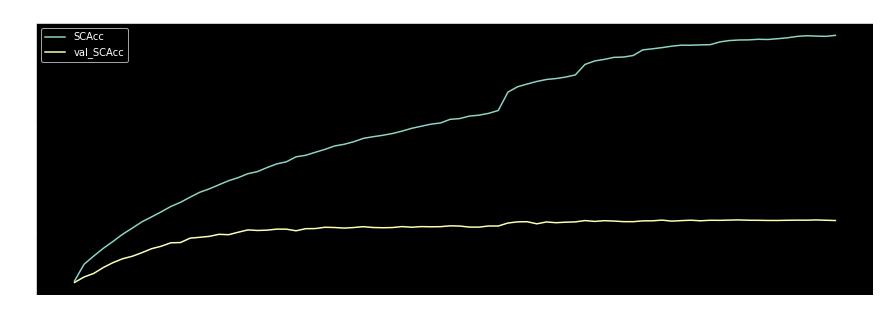

In [70]:
temp = pd.DataFrame(hist.history)
temp[["loss", 'val_loss']].plot(figsize=(15, 5), title="Loss Plot");
temp[["SCAcc", 'val_SCAcc']].plot(figsize=(15, 5), title="Metric Plot");

#### Model Prediction:
Let's now predict with the test data. It requires a bit of 
preprocessing:

In [71]:
# repeat the same for the test dataset
test_data = pd.DataFrame({"X": test.groupby("user_id")['ccode'].progress_apply(lambda x: x.values)})
test_data.head()

100%|██████████| 39732/39732 [00:03<00:00, 12816.93it/s]


,X
user_id,
4577,"[374, 451, 1421, 1419, 233, 182, 1462, 1636, 2..."
4578,"[182, 374, 1421, 451, 493, 233, 1636, 1419, 14..."
4579,"[3421, 3422, 3423, 3424, 3425, 3426, 3427, 342..."
4583,"[182, 374, 493, 233, 367, 451, 1636, 300, 1039..."
4584,"[374, 493, 1636, 367, 233, 1421, 447, 2228, 16..."


In [72]:
# intially partial challenge is fully NULL padded
pad_ = np.repeat(np.array([data.ccode.max()+1] * 2).reshape(1, -1), repeats=len(test_data), axis=0)

for i in range(2): # repeat 3x (last time we do it outside loop)
    pred = model.predict(
        [np.stack(test_data.X),
        pad_]
    )

    test_data['Y'+str(i+1)] = np.argmax(pred, axis=1)
    # update the partial challenge with predicted value
    pad_[:, i] = test_data['Y'+str(i+1)]

pred = model.predict(
    [np.stack(test_data.X), 
     pad_]
)

# for the pred obtained, argsort to find the top 3 likely recommendations
temp = np.argsort(pred, axis=1)[..., -1:-4:-1]
test_data['Y_Final'] = list(temp)
test_data.head()

,X,Y1,Y2,Y_Final
user_id,,,,
4577,"[374, 451, 1421, 1419, 233, 182, 1462, 1636, 2...",2222,399,"[2542, 210, 399]"
4578,"[182, 374, 1421, 451, 493, 233, 1636, 1419, 14...",1462,210,"[210, 655, 1462]"
4579,"[3421, 3422, 3423, 3424, 3425, 3426, 3427, 342...",3433,3433,"[3532, 3437, 3533]"
4583,"[182, 374, 493, 233, 367, 451, 1636, 300, 1039...",1421,1421,"[1462, 2228, 1421]"
4584,"[374, 493, 1636, 367, 233, 1421, 447, 2228, 16...",182,1462,"[1462, 1457, 182]"


Now that we have the top 5 recommendations in that order, we find that some recommendations are recurring, `Y_Final` will help us with that issue, we will only retain the top 3 unique challenge recommendations:

In [73]:
temp = (
    test_data.progress_apply(
        lambda x: np.unique([x['Y1'], x['Y2'], *x['Y_Final']])[:3], # only top 3
        axis=1)
    .progress_apply(pd.Series)
    .stack()
    .reset_index(level=1)
)

# map code back to challenge IDs
temp[0] = temp[0].map(rev_mapping)
temp['user_sequence'] = (temp.index.astype(str) + "_1").values + (temp.level_1 + 1).astype(str).values

# make the submission file
temp.rename({0: 'challenge'}, axis=1).iloc[:, [-1, -2]].to_csv('seq_pred_sub.csv', index=False)

100%|██████████| 39732/39732 [00:07<00:00, 5002.68it/s] 


This model predictions scores: 0.13673488328924777 on the leaderboard.
